# Homework 4
### OPER 685 - Machine Learning I
### Hosley, Brandon

In [1]:
%load_ext ipydex.displaytools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from scipy import stats

randState = 42

## 1. (30 Points) Consider the data in auto.csv. Develop a model to predict whether a given car gets "high" or "low" gas mileage.  

In [2]:
auto_df = pd.read_csv('Auto.csv').replace('?', np.NaN).dropna()
auto_df['horsepower'] = pd.to_numeric( auto_df['horsepower'], errors='coerce')
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### a. (5 points) Create a binary variable, mpg01, that contains a value of 1 for samples that are above the median value of mpg and contains a value of zero for samples that are at or below that median value of mpg. Define "high" gas mileage as anything above this median value. 

In [3]:
# Change the response variable from boolean to integer encoding
med = np.median(auto_df.mpg)    # Define mean MPG for response variable
auto_y = pd.DataFrame()         # Response var instantiation/placeholder
auto_y['mpg01'] = pd.DataFrame( auto_df['mpg'] > med ).replace({True: 1, False: 0})

# Separate the regressors, drop response and string name
auto_X = auto_df.drop(['name','mpg'], axis=1)

# Train Test split
auto_testfraction = 0.2     # split ratio
auto_X_nonTest, auto_X_test, auto_y_nonTest, auto_y_test = train_test_split(auto_X, auto_y, test_size=auto_testfraction, random_state=randState)

### b. (5 points) Create and train a logistic regression model to predict mpg01.

In [4]:
auto_LR = LogisticRegression().fit(auto_X_nonTest, auto_y_nonTest)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### c. (5 points) Do you need to use a validation dataset?  Defend your answer.

Because there are no hyperparameters to tune, there is not any benefit to having a validation class. When the solver is not  ‘sag’, ‘saga’ or ‘liblinear’ the sklearn wrapper for the logistic regression process is deterministic. Above, the dataset was split into a train and test set alone so that we have an opportunity to evaluate the model below.

### d. (5 points) Do you need to scale the data used for training?  Defend your answer?

Consider the equation $$\pi(\mathbf X) = \frac{\exp(\beta_0 + \beta_1X_1 + \ldots + \beta_k X_k)}{1+\exp(\beta_0 + \beta_1X_1 + \ldots + \beta_k X_k)}.$$
The scaling is not necessary as the effect is that scale of the $\beta$'s change, in other words, dividing each element by the mean of the feature's values in the sample is equivalent to just dividing the $\beta$ by that same number.
$$ \beta_\text{standardized} = \frac{\beta_\text{unmodified}}{\bar{\mathbf x}}. $$

### e. (5 points) Show your model results using appropriate metrics.

Because the sklearn implementation of the logistic regression returns the integer class prediction rather than a probability, residual plot would not be very useful as, in this case all points would cluster around four points. A confusion matrix will provide more information to identify strengths and weaknesses in this model.

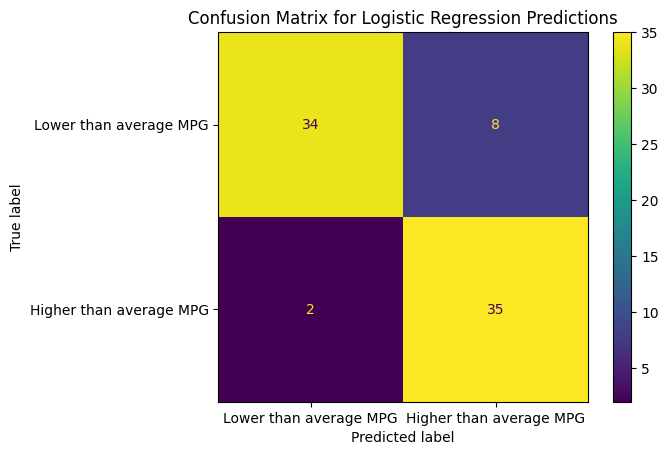

In [5]:
cm_auto = confusion_matrix(auto_y_test, auto_LR.predict(auto_X_test), labels=[0, 1])
disp_auto = ConfusionMatrixDisplay(confusion_matrix=cm_auto, display_labels=['Lower than average MPG', 'Higher than average MPG'])
disp_auto.plot()
plt.title('Confusion Matrix for Logistic Regression Predictions')
plt.show()

In [6]:
auto_TP = cm_auto[1,1]
auto_FP = cm_auto[0,1]
auto_FN = cm_auto[1,0]
auto_TN = cm_auto[0,0]

print(f'Accuracy : {(auto_TP+auto_TN)/np.sum(cm_auto)}')
print(f'Precision : {auto_TP/(auto_TP+auto_FP)}')
print(f'Recall : {auto_TP/(auto_TP+auto_FN)}')
print(f'F1-score : {(2*auto_TP)/(2*auto_TP+auto_FP+auto_FN)}')

Accuracy : 0.8734177215189873
Precision : 0.813953488372093
Recall : 0.9459459459459459
F1-score : 0.875


### f. (5 points) Analyze your model results, ensure you are using proper terminology and translating this terminology into a meaningful answer.

The results above suggest that the model is most effective at identifying the vehicles that are above average in MPG. The performance is fair by all other measurements. The most common error that this model makes is mistaking a low MPG vehicle for a high MPG one. This may be problematic if the stakeholder's intention is to reduce fuel consumption. 

# 2. (35 Points) The file pizza.csv includes 147 samples with the following variables:
brand – Pizza brand (class label)
id – Sample analyzed
mois – Amount of water per 100 grams in the sample
prot – Amount of protein per 100 grams in the sample
fat – Amount of fat per 100 grams in the sample
ash – Amount of ash per 100 grams in the sample
sodium – Amount of sodium per 100 grams in the sample
carb – Amount of carbohydrates per 100 grams in the sample
cal – Amount of calories per 100 grams in the sample
### (15 points) Apply both PCA and LDA to the data.
Address the comments and questions below.

In [7]:
pizza_df = pd.read_csv('pizza.csv')
pizza_df.info() ##:

# Response Variables
pizza_y = pizza_df['brand']

# Features, normalized
pizza_X = pizza_df.drop(['brand','id'], axis=1)
pizza_scaler = StandardScaler(with_mean=True)
pizza_X[pizza_X.columns] = pizza_scaler.fit_transform(pizza_X[pizza_X.columns])

# Train-test split
## Not performed as performance is not requested below.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   brand   147 non-null    object 
 1   id      147 non-null    int64  
 2   mois    147 non-null    float64
 3   prot    147 non-null    float64
 4   fat     147 non-null    float64
 5   ash     147 non-null    float64
 6   sodium  147 non-null    float64
 7   carb    147 non-null    float64
 8   cal     147 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 10.5+ KB


(pizza_df.info()) := None

---

### (a) (5 points) What percentage of the total variance is explained by the first two principal components? Calculate this "by-hand" (i.e., do not use the built in "explained_variance_ratio_" function).

In [8]:
dims = [0,1]
pizza_pca_eigVals, pizza_pca_eigVecs = np.linalg.eig( pizza_X.cov() ) 
pizza_pca_eigVals[dims] / np.sum(pizza_pca_eigVals) ##:

# Do the bad thing to confirm answer
PCA(n_components=len(dims)).fit(pizza_X, pizza_y).explained_variance_ratio_ ##:

(pizza_pca_eigVals[dims] / np.sum(pizza_pca_eigVals)) := 
array([0.57712476, 0.33044006])

---

(PCA(n_components=len(dims)).fit(pizza_X, pizza_y).explained_variance_ratio_) := 
array([0.57712476, 0.33044006])

---

The first two components explain 57.712% and 33.044% respectively.

### (b) (5 points) What percentage of between-group variance is explained by the first two discriminants?  Calculate this "by-hand" (i.e., do not use the built in "explained_variance_ratio_" function).

In [9]:
def lda(X, y):
    # Calculate class means (\bar{y})
    class_means = []
    classes = np.unique(y)
    for c in classes:
        class_means.append(np.mean(X[y == c], axis=0))
    class_means = np.array(class_means)
    
    # Calculate within-class scatter matrix (Sw)
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))
    for i,c in enumerate(classes):
        X_c = X[y == c]
        diff = X_c - class_means[i]
        Sw += np.dot(diff.T, diff)
    
    # Calculate between-class scatter matrix (Sb)
    sample_mean = np.mean(X, axis=0)
    Sb = np.zeros((n_features, n_features))
    for i,c in enumerate(classes):
        n_samples = X[y == c].shape[0]
        diff = class_means[i] - sample_mean
        Sb += n_samples * np.outer(diff, diff)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    return eigenvalues, eigenvectors

pizza_lda_eigVals, pizza_lda_eigVecs = lda(pizza_X, pizza_y)
pizza_lda_eigVals[dims] / np.sum(pizza_lda_eigVals) ##:

# Do the bad thing to confirm answer
LDA(n_components=len(dims)).fit(pizza_X, pizza_y).explained_variance_ratio_ ##:

(pizza_lda_eigVals[dims] / np.sum(pizza_lda_eigVals)) := 
array([0.66535998, 0.20635691])

---

(LDA(n_components=len(dims)).fit(pizza_X, pizza_y).explained_variance_ratio_) := 
array([0.66535998, 0.20635691])

---

### (c) (5 points) Plot the data in two-dimensional space using PCA. Plot the data in two-dimensional space using LDA. Discuss any insights you obtain. (Make sure the graphs are labeled)

[Text(0.5, 1.0, '2D LD MDS'), None]

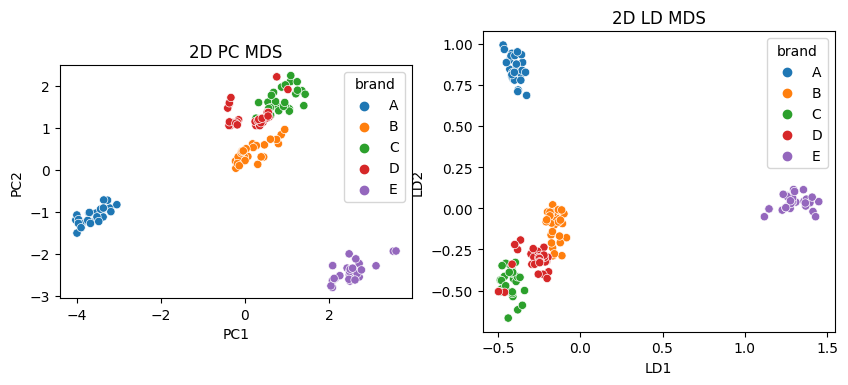

In [10]:
pizza_pca_coords = pizza_X@pizza_pca_eigVecs[:,dims]
pizza_pca_coords = pizza_pca_coords.rename(columns={0: 'PC1', 1: 'PC2'})

pizza_lda_coords = pizza_X@pizza_lda_eigVecs[:,dims]
pizza_lda_coords = pizza_lda_coords.rename(columns={0: 'LD1', 1: 'LD2'})

pizza_pca_coords['brand'] = pizza_lda_coords['brand'] = pizza_y

# Plot in R^2 space
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,10])
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(data=pizza_pca_coords, x='PC1', y='PC2', hue='brand', ax=ax1).set(title='2D PC MDS', aspect=1) 
sns.scatterplot(data=pizza_lda_coords, x='LD1', y='LD2', hue='brand', ax=ax2).set(title='2D LD MDS', aspect=1) 

The axes scales are different, but the relative scales between each other remain approximately the same. The clusters of brands A and E show that the two a similar to reflections of the other across a $y=-x$ type line, and the shapes of the clusters remain somewhat similar. Brands B, C, and D remain in the expected order for the same reflection previously discussed. 

Looking at the principle components one can imagine the data points projected onto each of the individual components (axes) and in both cases there appears to be usable separation between A and E; whereas there appears to be almost no separation between B, C, and D along the first component, and a small amount of separation along the second component. Projecting onto the plane of both components shows fairly clear separation, however, the BCD clusters are close together and appear to have non-linear decision barriers (curved or discontinuous). 

The LDA is very similar, with the most significant difference is the last observation above. As promised in the name, the LDA model provides clear patterns in which one may place linear decision boundaries; not only that, there appears to be adequate space for each of the decision boundaries to be collinear. 

### (d) (5 points) Using LDA, classify the following sample: mois –50  prot –13  fat –25  ash –3  sodium –1  carb –5  cal –31

In [11]:
new_sample = pizza_scaler.transform(pd.DataFrame(
    [[-50, -13, -25, -3, -1, -5, -31]],
    columns= ['mois', 'prot', 'fat', 'ash', 'sodium', 'carb', 'cal']))


pizz_lda = LDA(n_components=len(dims)).fit(pizza_X, pizza_y)
print(f'This LDA model predicts the novel sample to be {pizz_lda.predict(new_sample)[0]}.')

This LDA model predicts the novel sample to be E.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


## 3. (35 Points) 
### The file winequality.csv contains 4898 data records on 11 aspects of a wine’s chemical makeup along with a score variable, "quality" (bad, normal, good). Build a classification model using a single decision tree along with at least one ensemble technique to examine the data. The goal of the assignment is to gain insight into how well a tree can classify the information and what kind of improvements, if any, are attainable via ensemble techniques.

In [12]:
wine_df = pd.read_csv('winequality.csv')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,normal
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,normal
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,normal
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,normal
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,normal


### (a) (5 points) Split the data into a training set and test/validation set.

In [13]:
test_ratio = 0.2
val_ratio = 0.2
wine_y = wine_df['quality']
wine_X = wine_df.drop('quality', axis=1)

wine_X_nonTest, wine_X_test, wine_y_nonTest, wine_y_test =\
    train_test_split(wine_X, wine_y, test_size=test_ratio)
wine_X_train, wine_X_val, wine_y_train, wine_y_val =\
    train_test_split(wine_X_nonTest, wine_y_nonTest, test_size=(1-test_ratio)*val_ratio)

wine_scaler = StandardScaler()
wine_X_train = wine_scaler.fit_transform(wine_X_train)
wine_X_val = wine_scaler.fit_transform(wine_X_val)
wine_X_test = wine_scaler.fit_transform(wine_X_test)

### (b) (5 points) Compute and show the confusion matrices for your decision tree model. What insights do these matrices give you?

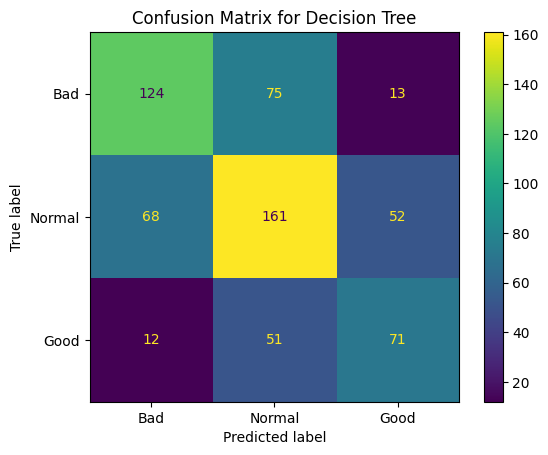

In [14]:
wine_tree = DecisionTreeClassifier()
wine_tree.fit(wine_X_train, wine_y_train)

wine_t_cm = confusion_matrix(wine_y_val, wine_tree.predict(wine_X_val), labels=['bad', 'normal', 'good'])
disp_wine = ConfusionMatrixDisplay(confusion_matrix=wine_t_cm, display_labels=['Bad', 'Normal', 'Good'])
disp_wine.plot()
plt.title('Confusion Matrix for Decision Tree')
plt.show()



### (c) (5 points) Using the same training and test data, compute and show the confusion matrices for your ensemble model. What insights do these matrices give you? Make sure you indicate which ensemble technique(s) you use.

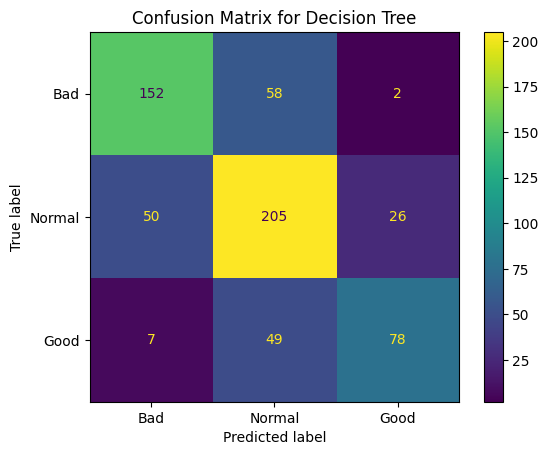

In [15]:
wine_forest = RandomForestClassifier()
wine_forest.fit(wine_X_train, wine_y_train)

wine_f_cm = confusion_matrix(wine_y_val, wine_forest.predict(wine_X_val), labels=['bad', 'normal', 'good'])
disp_wine = ConfusionMatrixDisplay(confusion_matrix=wine_f_cm, display_labels=['Bad', 'Normal', 'Good'])
disp_wine.plot()
plt.title('Confusion Matrix for Decision Tree')
plt.show()

### (d) (5 points) What features are considered to be important for your ensemble model’s predictions?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


,Feature,value,model
0,fixed acidity,0.072788,Random Forest
1,volatile acidity,0.099158,Random Forest
2,citric acid,0.077245,Random Forest
3,residual sugar,0.087601,Random Forest
4,chlorides,0.084166,Random Forest
5,free sulfur dioxide,0.094506,Random Forest
6,total sulfur dioxide,0.089212,Random Forest
7,density,0.111909,Random Forest
8,pH,0.083033,Random Forest
9,sulphates,0.076884,Random Forest


---

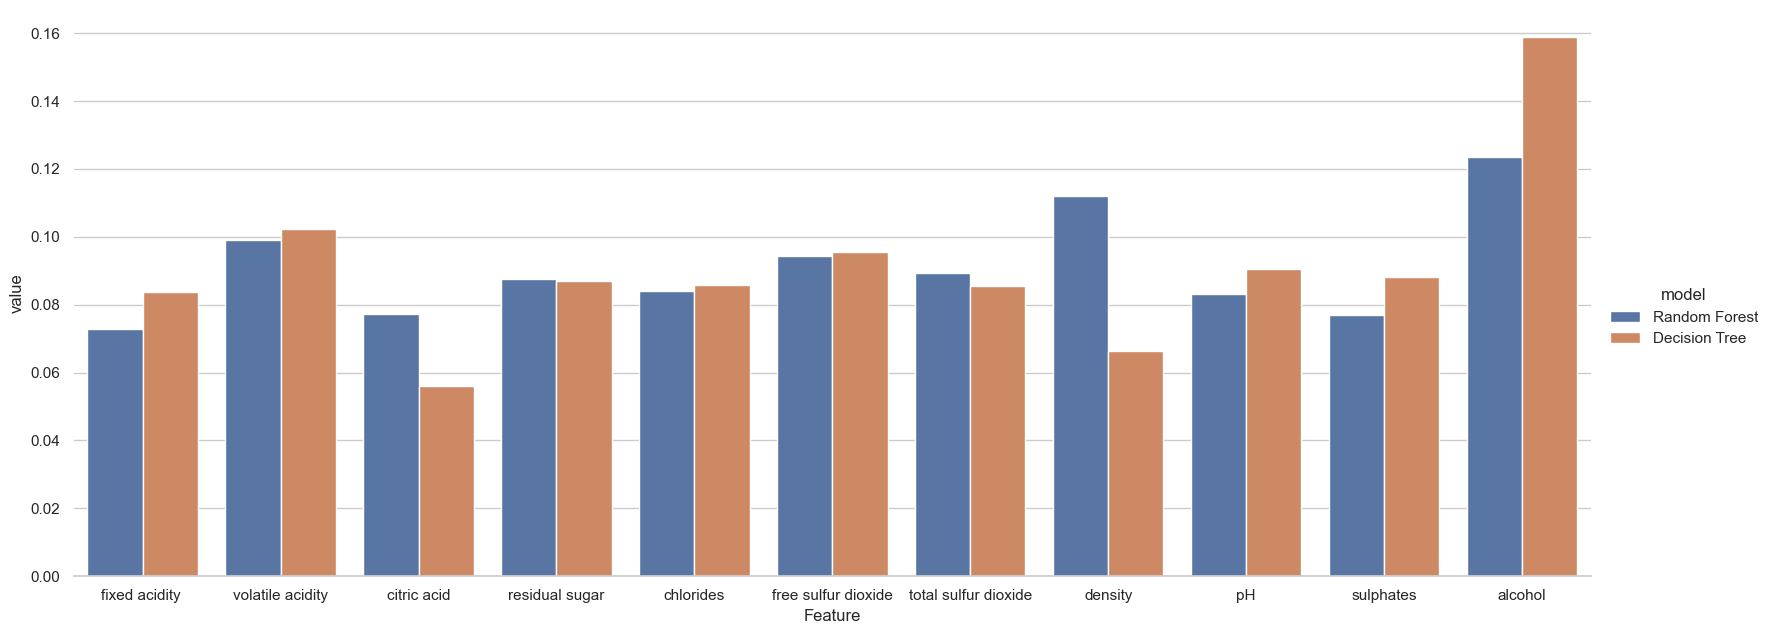

In [16]:
imp_tree, imp_forest = pd.DataFrame(columns=['Feature','value','model']), pd.DataFrame(columns=['Feature','value','model'])

imp_forest[['Feature','value','model']]= [wine_X.columns, wine_forest.feature_importances_, 'Random Forest']
imp_tree[['Feature','value','model']] = [wine_X.columns, wine_tree.feature_importances_, 'Decision Tree']
importances = pd.concat([imp_forest, imp_tree], ignore_index=True)

pd.DataFrame(importances).head(len(importances)) ##:
sns.set_theme(style="whitegrid")
sns.catplot(data = importances, kind='bar', x='Feature', y='value', hue='model',
            height=6.5, aspect=2.5).despine(left=True)

### (e) (5 points) Compare the results from each model. Which is best?

In [17]:
wine_t_cm.trace() / np.sum(wine_t_cm) ##:
wine_f_cm.trace() / np.sum(wine_f_cm) ##:

print( classification_report(wine_y_val, wine_tree.predict(wine_X_val)) )
print( classification_report(wine_y_val, wine_forest.predict(wine_X_val)) )

(wine_t_cm.trace() / np.sum(wine_t_cm)) := 0.5677830940988836

---

(wine_f_cm.trace() / np.sum(wine_f_cm)) := 0.69377990430622

---

              precision    recall  f1-score   support

         bad       0.61      0.58      0.60       212
        good       0.52      0.53      0.53       134
      normal       0.56      0.57      0.57       281

    accuracy                           0.57       627
   macro avg       0.56      0.56      0.56       627
weighted avg       0.57      0.57      0.57       627

              precision    recall  f1-score   support

         bad       0.73      0.72      0.72       212
        good       0.74      0.58      0.65       134
      normal       0.66      0.73      0.69       281

    accuracy                           0.69       627
   macro avg       0.71      0.68      0.69       627
weighted avg       0.70      0.69      0.69       627



The forest model outperforms the tree in all of the prediction metrics tested. It would appear that the only reasons to choose a decision tree is if there are technological limitations to consider.